In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams["font.size"] = 24
import glob
import sdf
import tqdm
from scipy.integrate import quad
from epoch_viz.viz import EpochViz

In [2]:
font = {
        'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 24,
    }

# The SG Envelope

In [3]:
def super_gaussian(t, T, p=2):
    if t < 0:
        return 0
    if t > T:
        return 0
    return np.exp(-((t-0.5*T)/(0.15*T))**p)

2.6586743198384877
1.0
1.0626454238745326
1.0984845999737727


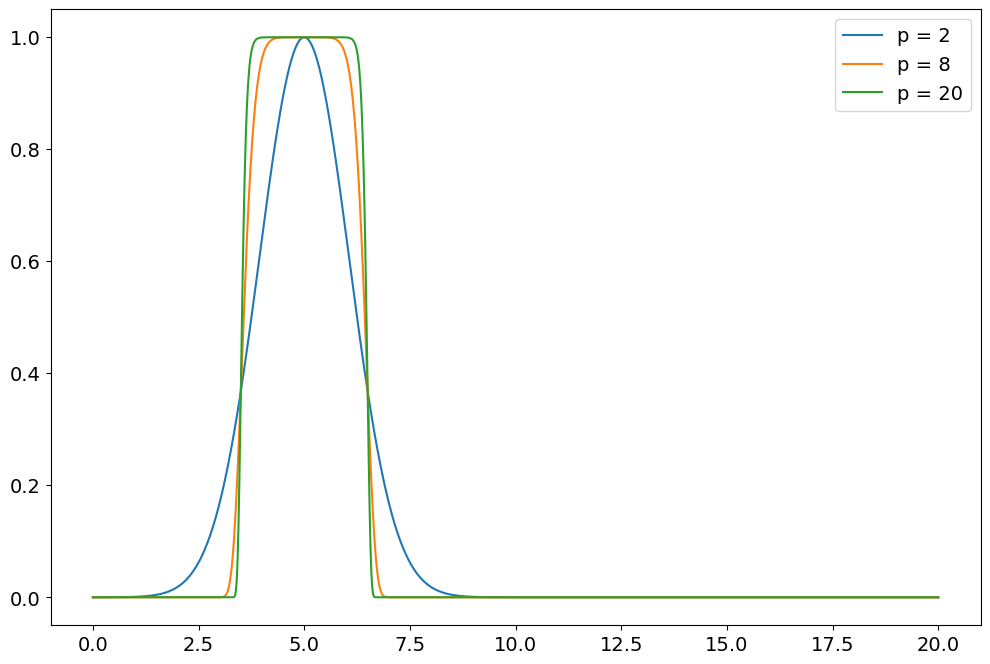

In [4]:
import matplotlib.pyplot as plt
T = 10
p = 2
Ts = np.linspace(0, 2*T, 1000)
curve = [super_gaussian(t, T, p) for t in Ts]
base_area = quad(super_gaussian, 0, T, args=(T, p))[0]
print(base_area)

ps = [2, 8, 20]
for p in ps:
    curve = [super_gaussian(t, T, p) for t in Ts]
    area = quad(super_gaussian, 0, 2*T, args=(T, p))[0]
    print(area/base_area)
    plt.plot(Ts, curve, label='p = {}'.format(p))
    
# plt.plot(Ts, [super_gaussian(t, T, p) for t in Ts], label='Super Gaussian')
# plt.xlabel('Time (fs)')
# plt.ylabel('Intensity (arb. units)')
plt.legend()

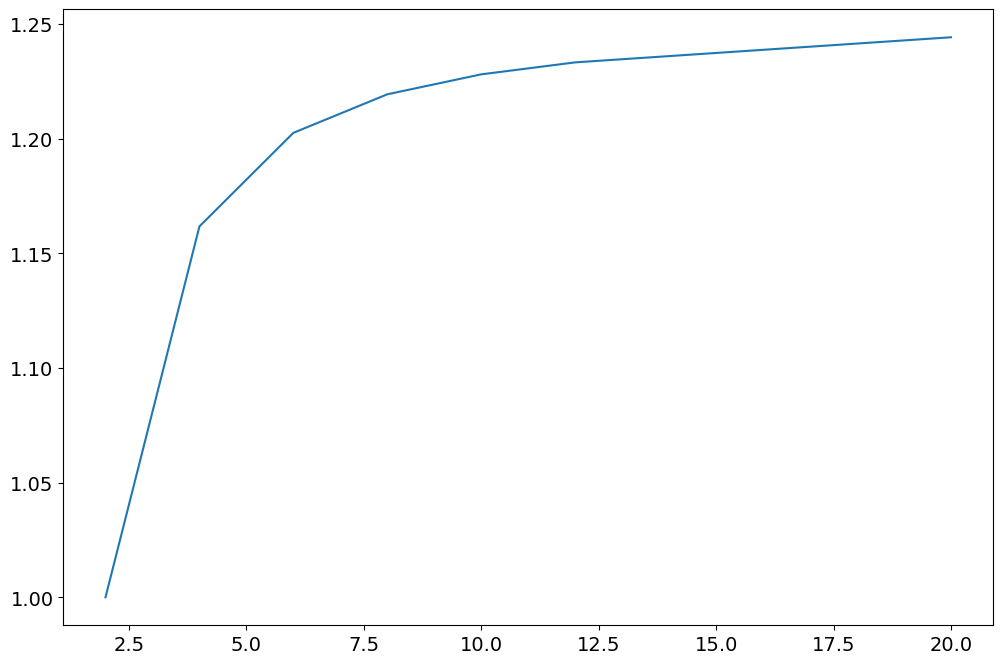

In [5]:
ratios = {
    2: 1.0,
    4: 1.1617448070082612,
    6: 1.2025442073509194,
    8: 1.2193552309287747,
    10: 1.2280600036588267,
    12: 1.2332802909912786,
    20: 1.2442253903686272,
}

plt.plot(list(ratios.keys()), list(ratios.values()))

# Results

In [5]:
def prepare(p):
    c = 3*1e8
    e = 1.6*1e-19
    m=9.1*1e-31
    lambda0 = 1e-6
    tau=lambda0/c
    las_time = 20*tau
    omega0 = 2*np.pi*c/lambda0
    Er = m * omega0 * c / e
    nx = 16000
    t_end =40*tau
    dt_snapshot = 0.08e-15
    x_min = -20*lambda0
    x_max = 20*lambda0
    factor =4
    epsilon = 8.85418782e-12
    nc = epsilon*m*omega0**2/e**2
    n0 = factor*nc


    las_time = 20
    DIR = f"SG_{p}"


    def super_gaus(t,p):
        mu=las_time/2
        sigma=las_time*0.15
        n = (t-mu)**p
        d = sigma**p
        e_0 = np.sin(2*np.pi*t)
        res = np.exp(-n/d)*e_0
        return res
    
    ez = EpochViz(DIR) 

    samples = len(ez.files)
    t_max = las_time
    t = np.linspace(0, t_max, samples)
    t2 = np.linspace(0, 2*t_max, samples)


    Ey,T,X = ez.load_data(['Ey'],
    normalize=False,
    space_range=[0, 8000],
    time_range=None,
    overwrite=True,
    return_data=True
        ) 
    omega, fy = ez.plot_fft(node = 8000, return_data=True, show_fig=False)
    return omega, fy


## Loading Data

In [6]:
data = {}
ps = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
for p in ps:
    omega, fy = prepare(p)
    data[f"omega_{p}"] = omega
    data[f"fy_{p}"] = fy

Loading Data...: 100%|██████████| 1669/1669 [00:04<00:00, 344.76it/s]


## Shift

In [8]:
data.keys()

dict_keys(['omega_2', 'fy_2', 'omega_4', 'fy_4', 'omega_6', 'fy_6', 'omega_8', 'fy_8', 'omega_10', 'fy_10', 'omega_12', 'fy_12', 'omega_14', 'fy_14', 'omega_16', 'fy_16', 'omega_18', 'fy_18', 'omega_20', 'fy_20'])

In [7]:
ps = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

In [8]:
def get_peak(harmonic, run):
    omega = data[f"omega_{run}"]
    fy = data[f"fy_{run}"]
    max_idx = np.where(np.isclose(omega, harmonic, atol=0.01))[0]
    return fy[max_idx]

In [9]:
peaks = {}
harmonics = [3, 5, 7, 9, 11]
for h in harmonics:
    peak = []
    for p in ps:
        res = get_peak(h, p)[0]
        # print(res)
        peak.append(res)
    peaks[h] = peak

/tmp/ipykernel_13145/2217865042.py:13: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(24)
/tmp/ipykernel_13145/2217865042.py:15: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(24)


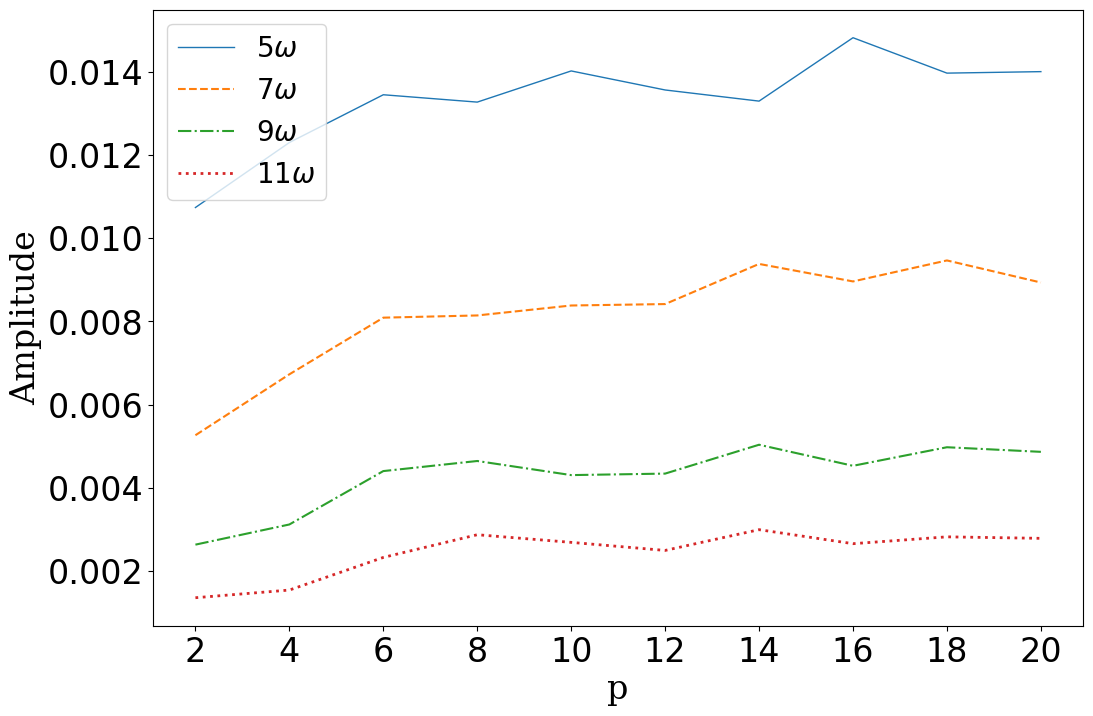

In [12]:
styles = ['-', '--', '-.', ':']
line_widths = [1, 1.5, 1.5, 2]
i = 0
for h in harmonics[1:]:
    plt.plot(ps, peaks[h], label=f"${h} \omega$", linestyle=styles[i], linewidth=line_widths[i])
    i+=1
plt.xticks(ps)
plt.legend()
plt.xlabel('p', fontdict=font)
plt.ylabel('Amplitude', fontdict=font)
# plt.yscale('log')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
plt.legend(fontsize = 20)
# plt.yscale("log")
plt.savefig('images/SG_peak_amplitude.png', dpi=200)

## FFTs

/tmp/ipykernel_25449/1889577544.py:18: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(24)
/tmp/ipykernel_25449/1889577544.py:20: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(24)


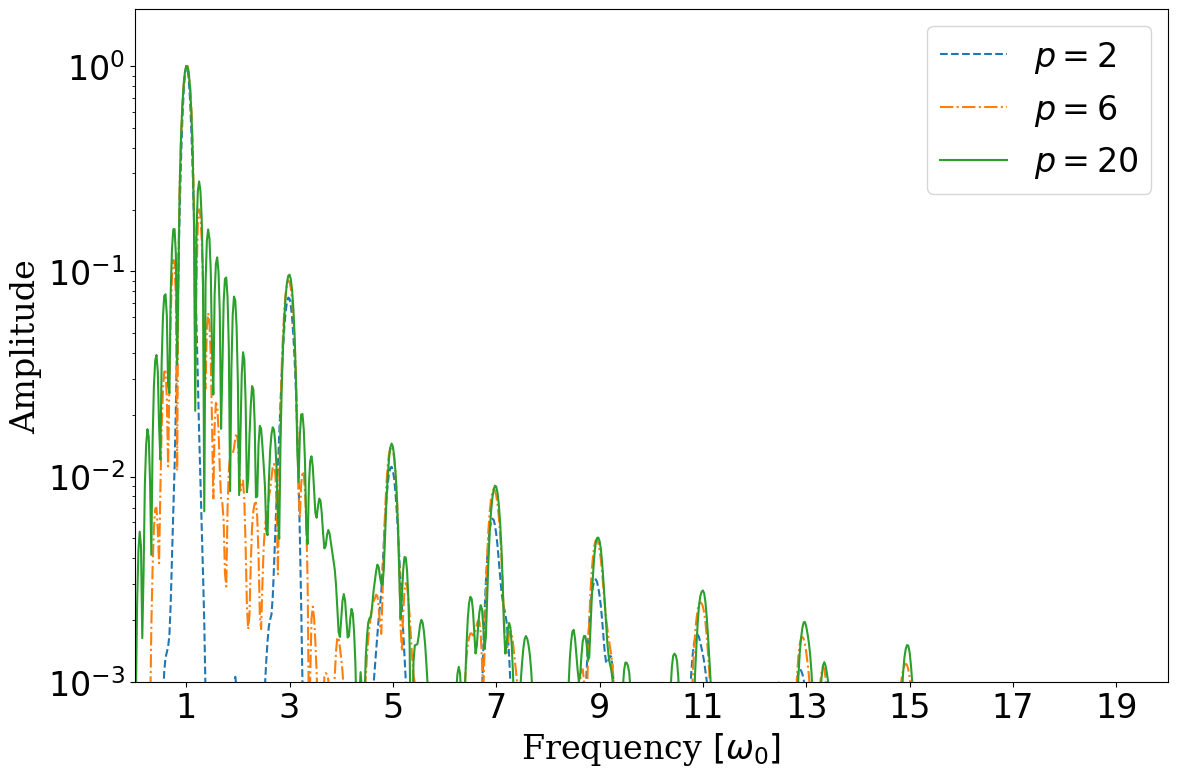

In [13]:
plt.figure()
ps = [2, 6, 20]
# ps = [2]
styles = ['--', '-.', '-']
i =0
for p in ps:
    omega = data[f"omega_{p}"]
    fy = data[f"fy_{p}"]
    plt.plot(omega, fy, label=f'$p={p}$', linestyle=styles[i])
    plt.xlabel(r'Frequency $[\omega_0]$', fontdict=font)
    plt.ylabel(r'Amplitude', fontdict=font)
    plt.yscale('log')
    plt.xlim(0, 20)
    plt.ylim(1e-3, )
    i+=1
plt.xticks(np.arange(1, 21, 2))
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
plt.legend(fontsize = 24)
plt.tight_layout()
plt.savefig(f"images/SG_ffts_{'-'.join([str(p) for p in ps])}.png", dpi=300)